In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from pyfolio.timeseries import perf_stats
%matplotlib inline

In [2]:
cash = 120000

In [3]:
df = pd.read_csv('/home/tomek/ib_tools/backtests/backtest_2020-08-30_20-35_20180601_20191231.csv')
del df['sys_time']
del df['exec_ids']
try:
    del df['perm_id']
    del df['com_reports']
except:
    pass
df['time'] = pd.to_datetime(df['time'])
df.set_index('time', inplace=True)
df['cash'] = df.realizedPNL.cumsum() + cash
df['contract'] = df['contract'].apply(lambda x: x[:-2])
df['contract'] = df['contract'].apply(lambda x: x[:2])

In [31]:
df[df['reason']=='CLOSE'].realizedPNL.count()/df.realizedPNL.count()*2

0.05592347314201619

In [4]:
#df = df[(df['contract'] == 'NQ') | (df['contract'] == 'ES') | (df['contract'] == 'YM')]

In [5]:
#df = df.loc['20190101':'20190701']

In [6]:
c = set(df['contract'])
allocs = pd.Series([1/len(c)]*len(c) +[1], index=list(c) + ['total'])
#allocs = pd.Series([1/3, 2/3, 1], index=['ES','NQ', 'total'])

In [7]:
allocs

GC       0.25
ES       0.25
YM       0.25
NQ       0.25
total    1.00
dtype: float64

In [8]:
df.groupby('contract').realizedPNL.sum()

contract
ES    14312.20
GC     9319.36
NQ    37839.80
YM    36911.60
Name: realizedPNL, dtype: float64

In [9]:
df.realizedPNL.sum()

98382.96

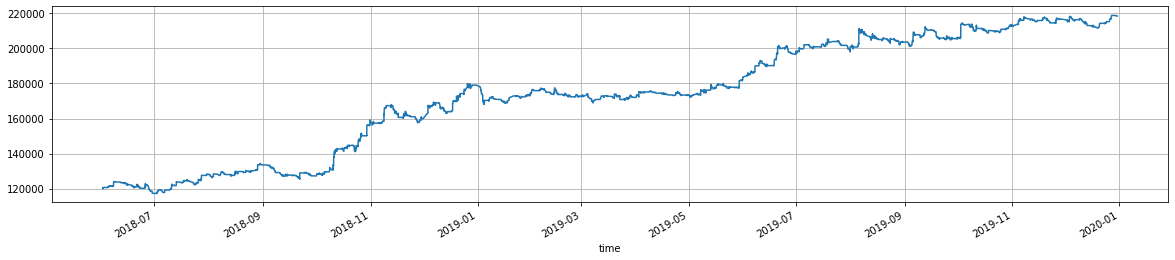

In [10]:
df.cash.plot(figsize=(20,4), grid=True);

In [11]:
by_contract = pd.pivot_table(df, values='realizedPNL', index=df.index, columns=['contract'])
by_contract['total'] = by_contract.sum(axis=1)

In [12]:
# number of trades
trades = df.groupby('contract').action.count()
trades, trades.sum()

(contract
 ES     518
 GC     992
 NQ    2013
 YM     554
 Name: action, dtype: int64,
 4077)

In [13]:
# trades per day
days = len(by_contract.resample('B').count().index)
trades/days, trades.sum()/days

(contract
 ES    1.257282
 GC    2.407767
 NQ    4.885922
 YM    1.344660
 Name: action, dtype: float64,
 9.895631067961165)

In [14]:
# commission paid
df.groupby('contract').commission.sum()

contract
ES    1087.80
GC    2400.64
NQ    4227.30
YM    1163.40
Name: commission, dtype: float64

In [15]:
df.commission.sum()

8879.140000000003

In [16]:
# per trade stats
exits = df[df.realizedPNL!=0]
dfs = {}
for contract in exits.contract.unique():
    dfs[contract] = exits[exits.contract == contract]
dfs['total'] = exits
results = pd.DataFrame(columns=['success_rate', 'average_PNL', 'average_gain', 'average_loss','win_ratio', 'EV',
                               'number_of_positions'])
for c, d in dfs.items():
    row = pd.Series()
    row['success_rate'] = round((d[d.realizedPNL > 0]).realizedPNL.count() / d.realizedPNL.count(), 2)
    row['average_PNL'] = round(d.realizedPNL.mean(), 2)
    row['average_gain'] = round((d[d.realizedPNL > 0]).realizedPNL.mean(), 2)
    row['average_loss'] = round((d[d.realizedPNL < 0]).realizedPNL.mean(), 2)
    row['win_ratio'] = round(abs(row['average_gain'] / row['average_loss']), 2)
    row['EV'] = round((row['average_gain'] * row['success_rate']) + (
        row['average_loss'] * (1 - row['success_rate'])), 2)
    row['number_of_positions'] = d.realizedPNL.count()
    results.loc[c] = row
results

,success_rate,average_PNL,average_gain,average_loss,win_ratio,EV,number_of_positions
GC,0.39,18.79,459.56,-257.23,1.79,22.32,496.0
NQ,0.40,37.61,464.96,-247.99,1.87,37.19,1006.0
ES,0.41,55.26,910.99,-547.13,1.67,50.70,259.0
YM,0.44,133.25,757.37,-350.83,2.16,136.78,277.0
total,0.40,48.27,564.81,-300.89,1.88,45.39,2038.0


In [17]:
daily = by_contract.resample('B').sum()
daily = daily /  (allocs * cash)
#daily[['CL', 'ES', 'GC', 'NQ']].plot(figsize=(20,8), grid=True);

In [18]:
# instrument correlations
log_returns = np.log(daily + 1)
log_returns.corr()

,ES,GC,NQ,YM,total
ES,1.000000,-0.033749,0.215462,0.547303,0.736345
GC,-0.033749,1.000000,0.084968,0.045445,0.349467
NQ,0.215462,0.084968,1.000000,0.237484,0.654159
YM,0.547303,0.045445,0.237484,1.000000,0.733723
total,0.736345,0.349467,0.654159,0.733723,1.000000


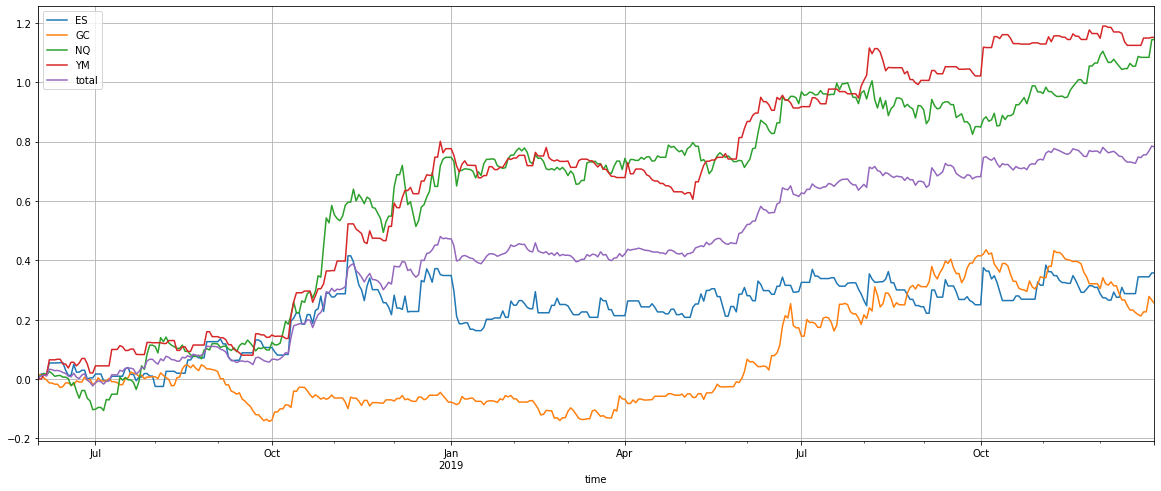

In [19]:
log_returns.cumsum().plot(figsize=(20,8), grid=True);

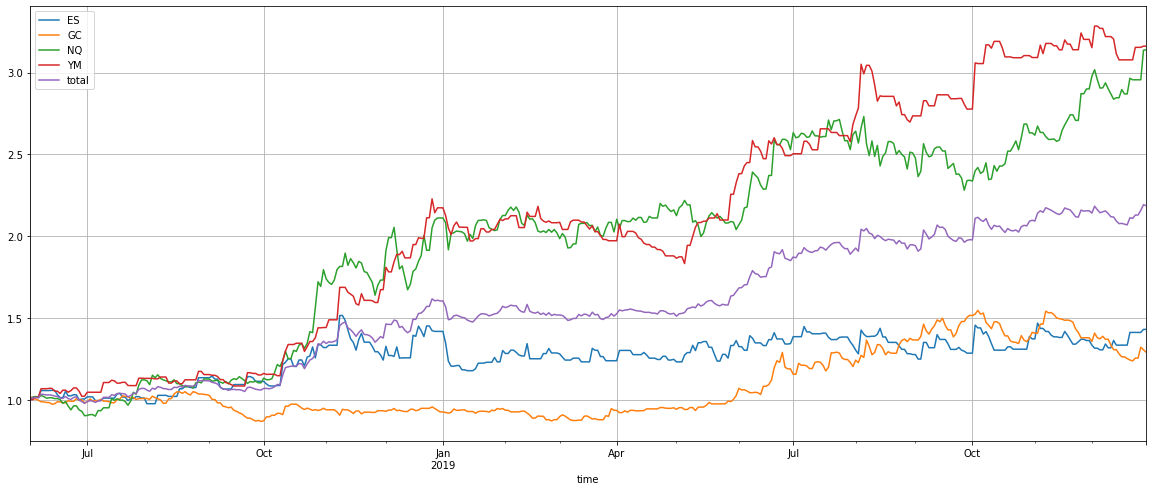

In [20]:
returns = daily.copy()
returns_index = (returns + 1).cumprod()
returns_index.plot(figsize=(20,8), grid=True);

In [21]:
stats = pd.DataFrame()
for col in daily.columns:
    stats[col] = perf_stats(daily[col])
stats

,ES,GC,NQ,YM,total
Annual return,0.244422,0.168303,1.013226,1.021956,0.613453
Cumulative returns,0.429765,0.289578,2.139354,2.161639,1.186074
Annual volatility,0.388275,0.264381,0.379344,0.313392,0.214735
Sharpe ratio,0.751535,0.718685,2.033753,2.401355,2.335283
Calmar ratio,1.096926,0.841627,5.448521,5.751285,7.009892
Stability,0.595200,0.579619,0.858071,0.927960,0.941823
Max drawdown,-0.222825,-0.199973,-0.185964,-0.177692,-0.087512
Omega ratio,1.192269,1.151506,1.461997,1.812226,1.577484
Sortino ratio,1.416922,1.262956,3.591931,5.565828,4.745693
Skew,1.867525,1.199629,0.775795,2.223920,1.627743


In [22]:
# monthly returns in percent
monthly_log_returns = log_returns.resample('M').sum()
monthly_returns = np.exp(monthly_log_returns)-1
round(monthly_returns, 4) * 100

,ES,GC,NQ,YM,total
time,,,,,
2018-06-30,0.40,-1.84,-9.80,2.08,-2.28
2018-07-31,0.62,2.66,24.28,10.73,9.39
2018-08-31,12.28,2.27,0.52,2.06,4.39
2018-09-30,-1.93,-15.87,-2.11,-0.21,-5.12
2018-10-31,18.56,9.31,62.72,25.19,28.21
2018-11-30,-5.80,-1.62,-3.54,16.06,1.44
2018-12-31,14.11,-0.77,21.93,29.92,16.46
2019-01-31,-8.24,2.28,0.73,-3.58,-2.04
2019-02-28,-1.16,-7.23,-5.03,-0.64,-3.41


In [23]:
# total returns by contract in percent
round(np.exp(monthly_log_returns.sum())-1, 2)* 100

ES        43.0
GC        29.0
NQ       214.0
YM       216.0
total    119.0
dtype: float64

In [24]:
df.sort_values('realizedPNL', ascending=False)[['contract', 'action', 'price', 'realizedPNL']]

,contract,action,price,realizedPNL
time,,,,
2018-11-08 15:07:00,ES,SELL,2805.00,4095.8
2018-11-08 20:40:30,YM,SELL,26089.00,4000.8
2019-10-02 21:00:00,ES,BUY,2893.75,3995.8
2018-10-10 21:49:30,ES,BUY,2814.25,3545.8
2019-08-05 21:22:30,ES,BUY,2843.00,3408.3
...,...,...,...,...
2019-01-03 00:00:00,ES,SELL,2485.50,-1179.2
2019-01-03 20:56:30,ES,SELL,2453.00,-1266.7
2018-12-10 13:56:30,ES,BUY,2638.75,-1329.2


In [25]:
daily.sort_values('total', ascending=False)

,ES,GC,NQ,YM,total
time,,,,,
2019-08-05,0.113610,0.036011,0.035793,0.096387,0.070450
2019-10-02,0.133193,0.006355,0.026633,0.101693,0.066969
2018-11-08,0.136527,-0.021323,0.010527,0.133360,0.064773
2018-12-03,0.067777,-0.003989,0.103553,0.081860,0.062300
2019-09-05,0.081527,0.054344,0.070387,0.033887,0.060036
...,...,...,...,...,...
2018-10-22,-0.029030,-0.009161,-0.021920,-0.037113,-0.024306
2019-02-14,-0.068753,-0.013656,-0.011473,-0.011973,-0.026464
2019-06-26,-0.022640,-0.070645,0.000000,-0.017307,-0.027648
